# Producing the Dicke States on a Quantum Computer

In the following a quantum circuit to produce the _Qubit Dicke States_ will be described. The theoretical derivation is heavily guided by the paper ["Dicke States as matrix product states"](https://arxiv.org/abs/2408.04729) by D. Raveh and R. I. Nepomechie. The final circuit implementation (that is also the one shown in the aforementioned paper) is derived from ["Deterministic Preparation of Dicke States"](https://arxiv.org/abs/1904.07358) by A. Bärtschi and S. Eidenbenz.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RYGate

from src.cnry import append_toffoli, append_cnx, append_cnry
from src.dicke import append_i_operator, append_u_operator, create_dicke_circuit, create_inc_unitary, \
    jupyter_produce_counts
from src.utility import DecompositionTargets
from tests.integration.test_dicke_prep import jupyter_test_status

## The Dicke States
While generalizable to arbitrary $d$-level qudit systems, we will focus on the Dicke states for qubit ($d=2$) systems here. A $n$-qubit system is fully described by a statevector $| \psi \rangle$ in a hilbert space $\mathcal{H}_n = (\mathbb{C}^2)^{\otimes n}$.

From the properties of the tensor product follows that this is of course a complex vector space with $2^n$ basis vectors. We can write this as $\mathcal{B} = \{ | k \rangle \ : \ k = 0, \dots 2^n - 1\}$. The basis of two makes it particularly useful to write these basis states as binary numbers:
$$
| k \rangle = | k_n \ \dots \ k_1 \rangle = | k_n \rangle \otimes \cdots \otimes | k_1 \rangle \qquad k_i \in \mathbb{F}_2 \qquad k = \sum_{i=1}^{n} k_i * 2^{i-1}
$$

In this representation it makes sense to introduce the _hamming weight_ of such a basis state as:
$$
\omega: \mathcal{B} \rightarrow \mathbb{N}_0, \qquad | k_{n} \ \dots \ k_1 \rangle \mapsto \#_1(\{ k_i \ : \ i = 1, \dots, n \})
$$

The Dicke states are a family of statevectors parameterized by the system size $n$ and some parameter $k \in [0, n]$. For concrete values of $n$ and $k$ the Dicke state is the equal superposition of all $n$-qubit basis states with hamming weight $k$ and is denoted with $|D^n_k \rangle$. More formally:
$$
\begin{align}
\Omega_k &= \{| j \rangle \in \mathcal{B} \ : \ \omega(| j \rangle) = k \} \qquad M_k = | \Omega_k |\\
| D^n_k \rangle &= {1 \over \sqrt{M_k}} \sum_{| j \rangle \in \Omega_k} | j \rangle
\end{align}
$$

The goal in this work is to design a parameterized preparation gate $\mathcal{U}_{n, k}$ that produces the Dicke states from an initial system $| \psi_\text{init} \rangle = | 0 \rangle$. This gate may of course require some ancilla qubits, resulting in:
$$
\mathcal{U}_{n, k} \ : \ | 0 \rangle_\text{aux} \otimes | 0 \rangle_n \mapsto | \xi \rangle_\text{aux} \otimes | D^n_k \rangle
$$

## Matrix Product States

### General
Before tackling a concrete implementation for a preparation gate $\mathcal{U}_{n, k}$ for the Dicke states, we want to present them in a more manageable form. For this we make use of a technique borrowed from tensor networks, called _Matrix Product States (MPS)_. A matrix product state is an implicit representation of a statevector that requires a _tensor contraction_ to calculate the coefficients. For introductory purposes we assume some boundary conditions are applied, then the MPS of a statevector $| \psi \rangle \in \mathcal{H}_n$ can be presented as a tensor network:

![image](images/mps_no_boundary_condition.png)

Notice that there are $n$ tensors $A_j$ locally connected by some so-called _virtual bonds_ and each having an open leg of dimension $2$. We can see that this is just a statevector by grouping all the open legs to a single one and obtaining a tensor with one open leg (i.e. a vector) of dimension $2^n$. A beautiful aspect of the MPS representation is, that we can identify each tensor with a spin-site of our physical system (i.e. a qubit of our quantum computer) and can then "index" them using the binary representation of our basis state to get the corresponding coefficient.

> **Organization of Qubits:**
>
> In this work physical sites are arranged in a left-to-right order, where the rightmost site refers to the _most significant bit (MSB)_ of the binary representation of the basis state. Qubits on the other hands are organized top-to-bottom, where the last qubit refers to the MSB of the basis state.

The contractions can also be written symbolically. For this we write $A^{k_j}_j$ for the projection of the tensor $A_j$ where $k_j \in \mathbb{F}_2$ is fixed for the open leg (analogous to applying the binary representation of a basis state $| k \rangle$). Effectively we are removing the open legs from the network and are left with a single complex number when fully contracted - the coefficient of the basis state. We can write:
$$
| \psi \rangle = \sum_k A^{k_n}_n \ \cdots \ A^{k_1}_1 | k \rangle
$$
The product in the summation has to be interpreted as a contraction, i.e. the dot-/matrix-vector-/matrix-matrix-product depending on the operands. Specifically $A^{k_n}_n$ is a row vector, $A^{k_1}_1$ is a column vector and the other tensors are all matrices. The dimensions are of course determined by the dimension of the virtual bonds $\chi_j$.


### Introducing Boundary Conditions
In the previous description the tensors at the border sites had a different form (i.e. lower degree). We can avoid this by introducing left and right boundary conditions. These are just two mre open legs at the two endpoints of the MPS making all the $A_j$ tensors of degree $3$. Their dimension can be chosen arbitrarily, just like the virtual bond dimensions, and are denoted by $\chi_0, \chi_{n + 1}$. The resulting network looks as follows:

![image](images/mps_with_boundary_condition.png)

In this case applying a binary representation of a basis state does no longer lead to a single complex number, but rather to a tensor with to open legs. Of course  this is expected as no boundary conditions have been applied yet. We realize that the MPS now describes an entire family of states, parameterized by a bra vector $\langle \bar{L} |$ and a ket vector $| \bar{R} \rangle$. Note that the Bra-Ket notation is chosen because of the interpretation of the contracted network as a matrix. It also matches the notation used in the aforementioned papers. The final symbolic form of the MPS becomes:
$$
| \psi \rangle = \sum_k (\langle \bar{L} | A^{k_n}_n \ \cdots \ A^{k_1}_1 | \bar{R} \rangle) | k \rangle
$$

Here $| \psi \rangle$ is a concrete statevector resulting from applying the boundary conditions $\langle \bar{L} |$ and $| \bar{R} \rangle$ to the MPS. Note that a representation as an MPS with some boundary conditions exists for every statevector $| \psi \rangle$ when the maximum virtual bond dimension $\chi = \max_{j} \chi_j$ is chosen large enough. The smallest value for $\chi$ is called the _Schmidt rank_. From now on we will assume that all other virtual bond dimensions are extended to $\chi$ and all $A^{k_j}_j$ have dimension $\chi \times \chi$.

### Canonical Form and Preparation
We are specifically interested in the canonical form of the MPS, which will help us to prepare $| \psi \rangle$ on a quantum computer. An MPS is called _canonical_
(more accurately _left canonical_) when:
 $$
 \sum_{m \in \mathbb{F}_2} A_j^{m \dagger} A_j^m = \mathbb{1} \qquad \text{for all} \ A_j
 $$

The deciding property of such a canonical MPS is, that there always exists a unitary $U_j$ operating on a single auxiliary qudit $| \bar{\phi} \rangle$ (with $\chi$ levels) and a qubit such that:
$$
U_j (| \bar{\phi} \rangle \otimes | 0 \rangle) = \sum_{m \in \mathbb{F}_2} (A_j^m| \bar{\phi} \rangle) | m \rangle \qquad \text{for all} \ | \bar{\phi} \rangle
$$

We now extend the $U_j$ to operate on the entire $n$-qubit system, leaving all qubits invariant but the one at site $j$. When we chain unitary operators and apply them to the state $| \bar{R} \rangle^{\otimes n}$ we obtain:
$$
U_n \cdots U_1 (| \bar{R} \rangle \otimes | 0 \rangle^{\otimes n}) = \sum_k (A_n^{k_n} \cdots A_1^{k_1} | \bar{R} \rangle) \otimes | k \rangle = | \bar{L} \rangle \otimes | \psi \rangle
$$

The only additional assumption for the above equality is, that the ancilla qudit decouples from the $n$-qubit system. This is the case for the MPS we discuss here.

One can see how the unitary chain above allows us to prepare pretty much any MPS on a quantum computer when we are able to:
+ Produce the right boundary condition state $| \bar{R} \rangle$
+ Emulate a $\chi$-level qudit on our two-state quantum computer.

These points will be discussed later. For now, we only have to find an MPS representation for the Dicke States.

## Application to Dicke States

### MPS Form of Dicke States
We leave out the derivation and immediately state the MPS form as given in the paper. Note that the virtual bond dimension for such a Dicke MPS is given by $\chi = k + 1$. We have:
$$
| D^n_k \rangle = \sum_m (\langle \bar{k} | A_n^{m_n} \cdots A_1^{m_1} | \bar{0} \rangle) \otimes | m \rangle
$$

Where the $A_j^{m_j}$ are of course $(\chi + 1) \times (\chi + 1)$-matrices with entries given by:
$$
(A_{j}^{m})_{r, s} = { c(n, k, j, s + m) * c(j, s + m, j - 1, s) \over c(n, k, j - 1, s) } \delta_{r, s + m}
$$

Here $c(n, k, i, j)$ refers to the _hypergeometric distribution_ given by:
$$
c(n, k, i, j) = \sqrt{\binom{i}{j} \binom{n - i}{k - j} \over \binom{n}{k}}
$$

Strictly speaking this MPS is not canonical in the sense $\sum_m A_j^{m\dagger} A_j^m = \mathbb{1}$, but it is close enough to canonical that there are still unitary matrices $U_j$ to prepare it, following the procedure for canonical MPS.

### Construction of the Unitary Operators
We follow the paper once again and make the ansatz, that the unitary operators for the MPS can be written as a product of simpler operators:
$$
U_j = \prod_{l=k}^{0} I_l^{(j)} = \prod_{l = \min(j-1, k-1)}^{\max(0, j - n + k + 1)} I_l^{(j)}
$$

We describe $I_l^{(j)}$ by describing the wanted action on the subsystem including the ancilla qudit and the qubit at site j:
$$
I^{(j)}_l |\bar{\psi}\rangle |0 \rangle_j = \begin{cases}
\sum_m (A^m_j | \bar{\psi} \rangle) | m \rangle_j & \text{if } \psi = l \\
|\bar{\psi}\rangle | 0 \rangle & \text{else.}
\end{cases}
$$

An example for a quantum circuit that has all the desired properties is given by:

![image](images/i_j_l_circuit.png)

In this circuit $\oplus, \ominus$ refer to an increment/decrement by $1$ taken modulus $\chi$. The rotation gate is controlled if the auxiliary qudit is in state $|\overline{l + 1 \ \mod \chi}\rangle$. The rotation angle is given by:
$$
\begin{align}
\theta &= 2 * \arccos \gamma^{(j)}_{(l \  \text{mod} \ \chi), 0} \\
\gamma^{(j)}_{r, 0} &= \begin{cases}
    \sqrt{1 + {(r-k) \over n - j + 1}} & \text{if} \quad k - r \le n - j + 1, \\
    0 & \text{else.}
\end{cases}
\end{align}
$$

Using the product at the beginning of this section we can assemble a circuit for all the unitary $U_j$. Then all that is left to do, is to assemble these unitary operators into the final operator $\mathcal{U}_{n, k} = U_n \cdots U_1$ that fulfills:
$$
\mathcal{U}_{n, k} (|\bar{0} \rangle \otimes | 0 \rangle^{\otimes n}) = | \bar{k} \rangle \otimes | D^n_k \rangle
$$


## Qiskit Implementation

### Qudit Emulation
As mentioned earlier we still have to take care of the $\chi$-level qudit, assuming we are working on a qubit-only quantum computer. This is not really a problem though because we can just use a register with $t = \lceil \log_2 \chi \rceil$ qubits to emulate the qudit. This register has $2^t$ basis states, of which we can identify the first $\chi$ with the basis states of the qudit. Every unitary operation $U$ on the qudit can now be emulated by applying an extended version $U^\ast$ to the qubit register:
$$
U^\ast: | j \rangle \ \mapsto \ \begin{cases}
    U | j \rangle & \text{if} \quad 0 \le j < \chi, \\
    | j \rangle & \text{else.}
\end{cases}
$$

> In the special case of a single-level qudit (i.e. $k = 0$) the value for $t$ becomes $0$. This makes sense, as the physical system is trivial (the qudit only contains a non-physical phase factor) but is impractical for the construction algorithm later. We thus chose $t = \max(1, \lceil \log_2 \chi \rceil )$.

### Increment/Decrement Operator
The first components that will be implemented are the $\oplus$ (increment) and $\ominus$ (decrement) gates. These operate on the emulated qudit and thus need to be extended as described earlier. We will use the `QuantumCircuit.unitary(...)` operation to directly construct the circuit of the gate from the extended unitary matrix $U_\oplus^\ast$. The qudit operation $U_\oplus$ used is given by:
$$
U_\oplus \ : \ | \bar{j} \rangle \mapsto | \overline{j + 1 \mod \chi} \rangle
$$

And of course we have $U_\ominus = U_\oplus^\dagger$. The following is an example of $U_\oplus$ for $\chi = 5$:

In [2]:
print(create_inc_unitary(5, invert=False).real.astype(int))

[[0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


We can see how this unitary is pretty much just an instance of a permutation matrix, that only "rotates" the first $5$ basis states and leaves the $3$ unused basis states invariant.

### $I$ Operator
The $I_l^{(j)}$ operator is described in the aforementioned papers to be implemented using a controlled $y$-Rotation and controlled versions of $\oplus$ and $\ominus$. It operates on one system qubit at site $j$ and the auxiliary qudit. In the paper $R(\theta)$ is dependent on the qudit value. As the gate is active only when the qudit is in state $| \overline{l + 1 \mod \chi} \rangle$ we can just fix $\theta_l = 2 * \arccos(\gamma_{l, 0}^{j})$.

For example choosing $n=2$ system qubits and $k=1$, we require a qudit with $\chi = 2$ levels (i.e. a sigle third qubit) and obtain:

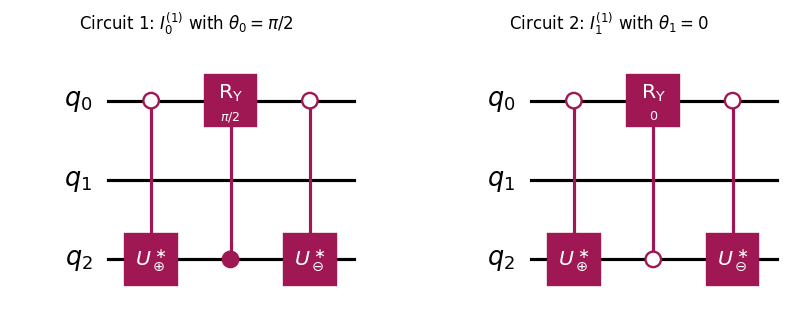

In [3]:
circuit_l_0 = QuantumCircuit(3)
circuit_l_1 = QuantumCircuit(3)
append_i_operator(circuit_l_0, 0, 1, [0, 1], [2], 2, -1, -1)
append_i_operator(circuit_l_1, 1, 1, [0, 1], [2], 2, -1, -1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Draw the first circuit
circuit_l_0.draw(output='mpl', ax=axes[0])
axes[0].set_title("Circuit 1: $I_0^{(1)}$ with $\\theta_0=\\pi / 2$")

# Draw the second circuit
circuit_l_1.draw(output='mpl', ax=axes[1])
axes[1].set_title("Circuit 2: $I_1^{(1)}$ with $\\theta_1=0$")

plt.show()

Note, that the right circuit simplifies to $\mathbb{1}$ and has no effect. That is why the product making up the $U_j$ operators can be restricted.

### $U$ Operator
The $U_j$ operators are just products of $I^{(j)}_l$ operators for a restricted range of $l$ (as described above). Keeping the values as in the previous example, we get the following circuit for system site $j = 1$:

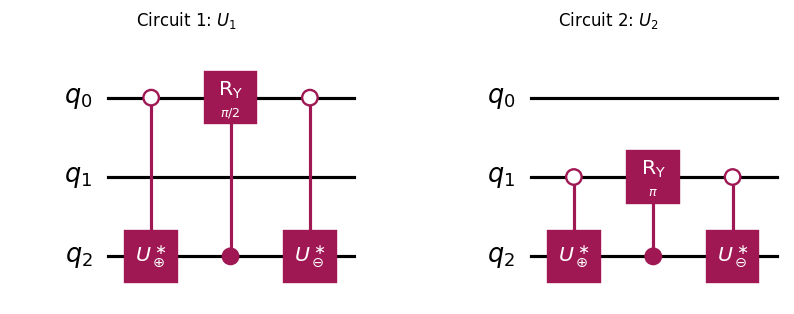

In [4]:
circuit_j_1 = QuantumCircuit(3)
circuit_j_2 = QuantumCircuit(3)
append_u_operator(circuit_j_1, 1, [0, 1], [2], 2, -1, -1)
append_u_operator(circuit_j_2, 2, [0, 1], [2], 2, -1, -1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Draw the first circuit
circuit_j_1.draw(output='mpl', ax=axes[0])
axes[0].set_title("Circuit 1: $U_1$")

circuit_j_2.draw(output='mpl', ax=axes[1])
axes[1].set_title("Circuit 2: $U_2$")

plt.show()

### $\mathcal{U}$ Operator
All that is left is to show the implementation of the entire preparation operator $\mathcal{U}^n_k$. This is just the product of the local $U_j$ operators for each system site $j$. Keeping the exemplary parameters from before, the circuit to prepare $| D^2_1 \rangle$ is:

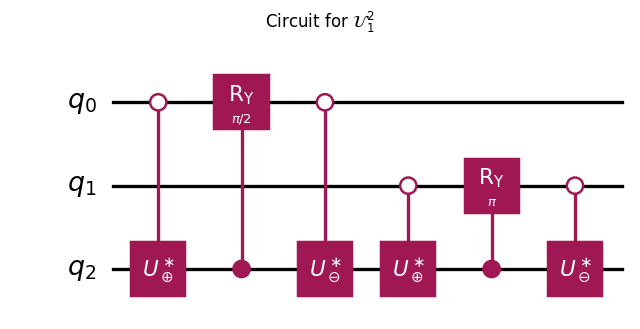

In [5]:
circuit = create_dicke_circuit(2, 1)

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# Draw the first circuit
circuit.draw(output='mpl', ax=axes)
axes.set_title("Circuit for $\\mathcal{U}^2_1$")

plt.show()

## Circuit Specification

### Verification
The tests in `tests.integration.test_dicke_prep.py` perform a brute force verification for all $0 < n < 5$ and possible respective values for $k$. The following field will fail display whether all tests pass:

In [6]:
jupyter_test_status()

'SUCCESS: The Dicke States are produced correctly!'

### Circuit Depth
The paper presents a closed form for the layer-depth of the circuit in terms of controlled $\oplus$, $\ominus$ and $R_y$ gates. It is given by:
 $$
 n_\text{layers} = 3 k (n + 1 - k)
 $$

For the example above, this yields $n_\text{layers} = 3 * 1 * (2 + 1 - 1) = 3 * 2 = 6$ as expected. Depending on the architecture the mentioned gate set might not be primitive though. In the following paragraph we discuss implementations of the operators with a more common primitive gate set and the resulting depth of the circuit.

### Qubit Count
The number of required qubits is simply the number of system qubits $n$ plus the number of qubits $t$, that are required to emulate the qudit. All in all we get:
$$
n_\text{qubits} = n + \max(1, \lceil \log_2 k + 1 \rceil)
$$

## Simple Gate Implementation

### Primitive Gate Set
In the following sections the implementation of the Dicke preparation operator $\mathcal{U}^n_k$ using a restricted set of gates is discussed. A primitive gate set is a set of operators that can be implemented physically on a quantum computer. Every operation has to decomposable into a combination of primitive gates to be executable on a quantum computer. The complete primitive gate set chosen for the following analysis is:
$$
\mathcal{G} = \{ X, H, T, T^\dagger, cX, cR_Y(\theta) \}
$$

This set is complete and is not even minimal in an algebraic sense. But as many platforms support all of these operations natively this choice of primitive gates is senseful and keeps the circuit depth reasonable.

### Multi-Controlled $R_Y$ Gates
We need a multi-controlled rotation around the $y$-axis, denoted as $c^nR_Y$ multiple times in the circuit. We will construct this in steps.

First we utilize a common decomposition of the Toffoli gate for $c^2X$:


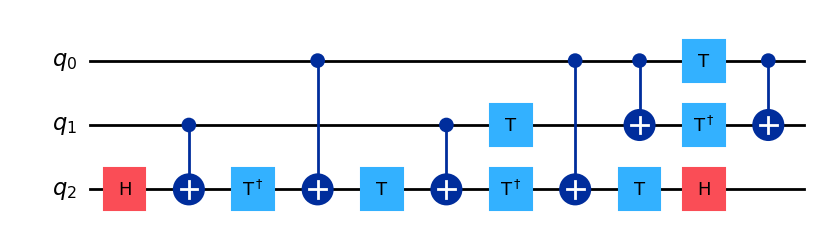

In [7]:
toffoli_circuit = QuantumCircuit(3)
append_toffoli(toffoli_circuit, 0, 1, 2, DecompositionTargets.TOFFOLI)
toffoli_circuit.draw("mpl")

For the sake of brevity we will just denote the Toffoli gate as an $X$ gate with two controls in the upcoming circuits. Keep in mind that these are not primitive though.

The next step is to construct a general $c^nX$ gate. There are methods to do this in-place (i.e. using only the control qubits and target qubit involved) but we will use an approach requiring a single clean ancilla qubit to reduce circuit depth and complexity. The approach is borrowed from ["Almost-Optimal Computational Basis State Transpositions"](https://arxiv.org/pdf/2309.12820) by S. Herbert, J. Sorci, Y. Tang. The circuit is built in two steps, splitting the control register into two sub-registers $| x \rangle$ and $| y \rangle$. These are displayed here as single qubits, $q_0$ and $q_1$. The target qubit is $q_2$ and the clean ancilla is $q_3$. The following circuit then implements a $c^nX$ gate, requiring a $c^{\lceil n /2 \rceil}X$ and $c^{\lfloor n /2 \rfloor + 1}X$ gate:

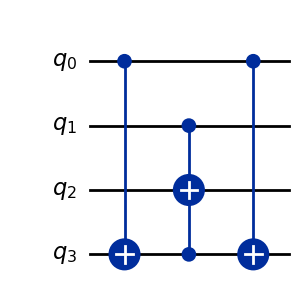

In [8]:
recursive_cnx_circuit = QuantumCircuit(4)
recursive_cnx_circuit.cx(0, 3)
recursive_cnx_circuit.ccx(1, 3, 2)
recursive_cnx_circuit.cx(0, 3)
recursive_cnx_circuit.draw("mpl")

The paper also discribes the implementation of the $c^{\lceil n /2 \rceil}X$ and $c^{\lfloor n /2 \rfloor + 1}X$ using the other control qubits as borrowed ancillas. A concrete implementation of a $c^5X$-gate using only Toffoli gates then becomes:

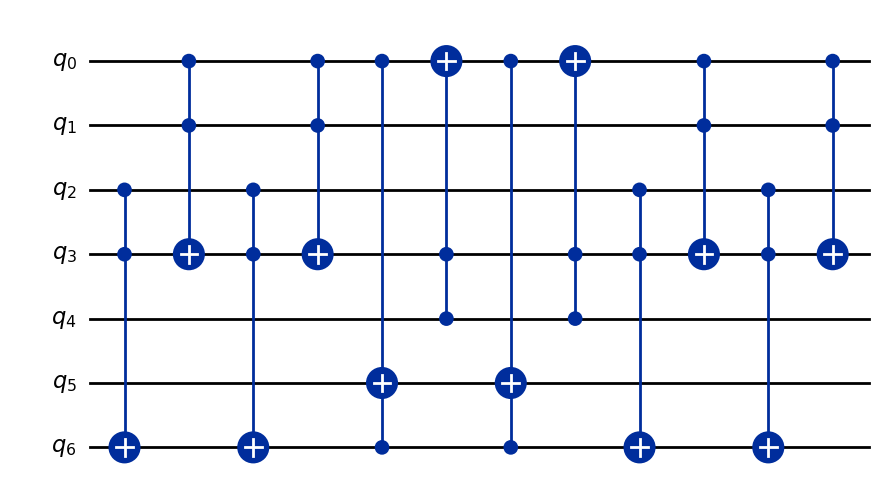

In [9]:
c5x_circuit = QuantumCircuit(7)
append_cnx(c5x_circuit, [0, 1, 2, 3, 4], 5, 6, DecompositionTargets.CNX)
c5x_circuit.draw("mpl")

Having $c^nX$ gates available, it is easy to construct a $c^nR_Y(\theta)$ gate using an additional ancilla qubit and $cR_Y(\theta)$. We simple encode the boolean value _Are all control qubits set?_ in the ancilla qubit and use that to control the $R_Y(\theta)$ gate on the target qubit. This results in the following form for $c^5R_Y(\pi)$:

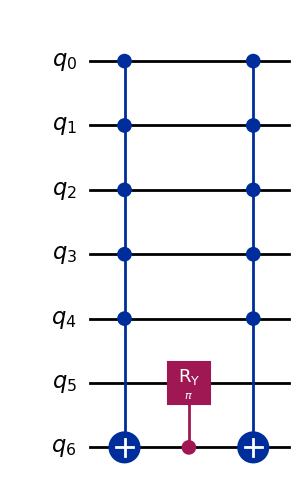

In [10]:
c5ry_circuit = QuantumCircuit(7)
append_cnry(c5ry_circuit, np.pi, [0, 1, 2, 3, 4], 5, 6, -1, DecompositionTargets.CNRY)
c5ry_circuit.draw("mpl")


### Increment/Decrement Operator
The first thing we note about the $\oplus$ and $\ominus$ gates is, that they provide the wanted functionality as a byproduct. From a functional standpoint we only need to apply a transposition operation to the qudit, switching $| \bar{l} \rangle$ with $| \overline{l + 1 \mod \chi} \rangle$. We do not care about how other basis states are mapped at all, because that mapping will never trigger the control and will be reversed right afterward. The simplest way to achieve this is to just use a series of single qubit $X$ gates at the mismatching positions of the binary representations of the basis states.

Let us assume $\chi = 8$ for example, meaning we are working with $t = 3$ qubits to emulate the qudit. We also assume $l = 3$, so we care about mapping $| 2 \rangle \leftrightarrow | 3 \rangle$ or in binary notation $| 010 \rangle \leftrightarrow | 011 \rangle$. This is most simply achieved by the circuit:

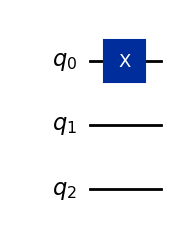

In [11]:
transpose_3_4_circuit = QuantumCircuit(3)
transpose_3_4_circuit.x(0)
transpose_3_4_circuit.draw("mpl")

One can see how we use a single $X$-gate at the LSB this is the only mismatching position.

The family of circuits of this form are all its own inverse and will be denoted $\mathcal{T}_{l, l'}$ for the circuit mapping $| l \rangle \leftrightarrow | l' \rangle$. One can see how we can replace all $\oplus$ and $\ominus$ occurences with the respective $\mathcal{T}_{l, l + 1 \ \text{mod} \ \chi}$ gates.

To get a single-qubit controlled version of a $\mathcal{T}$ gate, we only need to replace each $X$ gate with a $cX$ that is controlled by the single control qubit.

### $I$ Operator
Using the constructions above, our $I_l^{(j)}$ operators take on a new form. We need to introduce some more $\mathcal{T}$ gates because we only constructed a $| 1 \dots 1 \rangle$-controlled version of $C^nR_y(\theta)$. Besides that we need to flip the system qubit before applying the controlled $\mathcal{T}$ gates, because these should be $| 0 \rangle$-controlled. Taking all this into consideration will result in the following form of $I_l^{(j)}$, where $n = 2$, $k = 1$, $j = 1$, $l = 0$:

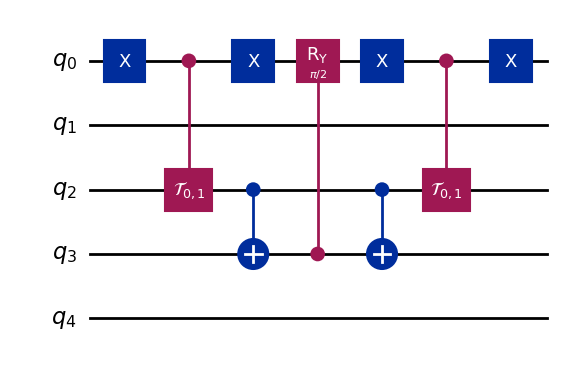

In [12]:
primitive_i_l_j_circuit = QuantumCircuit(5)
n = 2
k = 1
l = 0
append_i_operator(primitive_i_l_j_circuit, l, 1, [0, 1], [2], k + 1, 3, 4, DecompositionTargets.I_OP | DecompositionTargets.CNRY)
primitive_i_l_j_circuit.draw("mpl")

The last qubit is the ancilla for the $c^nX$-gates that is required in the general case.

## Primitive Circuit Complexity

### Primitive Gate Counts
The following table presents the gate counts for all the gates in $\mathcal{G}$ for some examples of $|D^n_k\rangle$-preparation circuits:

In [13]:
jupyter_produce_counts(DecompositionTargets.ALL)

,Circuit,X,H,T,T^dg,cX,cR_Y
0,D^2_2,16,8,16,12,30,2
1,D^3_2,32,16,32,24,60,4
2,D^3_3,20,12,24,18,44,3
3,D^5_4,88,96,192,144,316,8


For comparison, these are the gate counts of the abstract gates used in the original definition:

In [14]:
jupyter_produce_counts(DecompositionTargets.NONE)

,Circuit,c^nR_Y,cInc,cDec
0,D^2_2,2,2,2
1,D^3_2,4,4,4
2,D^3_3,3,3,3
3,D^5_4,8,8,8


### Adding the Toffoli Gate
Assuming our Quantum Computer natively supports the Toffoli gate, we get the following counts:

In [15]:
targets = DecompositionTargets.NONE
for t in DecompositionTargets.ALL:
    if t != DecompositionTargets.TOFFOLI:
        targets |= t

jupyter_produce_counts(targets)

,Circuit,X,cX,cR_Y,Toffoli
0,D^2_2,16,6,2,4
1,D^3_2,32,12,4,8
2,D^3_3,20,8,3,6
3,D^5_4,88,28,8,48
